In [3]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns

## Util functions to transform and visualize cells 

In [4]:
class Args:
    """
    Class to convert a dictionary into an object, allowing attribute-style access.

    Attributes:
        dictionary (dict): The dictionary to be converted into an object.
    """

    def __init__(self, dictionary):
        """
        Initializes the Args object with the provided dictionary.

        Parameters:
            dictionary (dict): The dictionary to be converted into an object.
        """
        self.__dict__ = dictionary

    def __getattr__(self, key):
        """
        Allows attribute-style access to dictionary values.

        Parameters:
            key (str): The key corresponding to the attribute being accessed.

        Returns:
            Any: The value associated with the key in the dictionary.

        Raises:
            AttributeError: If the key does not exist in the dictionary.
        """
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        """
        Allows calling the object to retrieve dictionary values.

        Parameters:
            key (str): The key corresponding to the attribute being accessed.

        Returns:
            Any: The value associated with the key in the dictionary.
        """
        return self.__getattr__(key)


def t2np(t):
    """
    Convert a PyTorch tensor to a NumPy array and normalize pixel values.

    Parameters:
        t (torch.Tensor): The PyTorch tensor to be converted.

    Returns:
        numpy.ndarray: The NumPy array representation of the tensor.
    """
    return ((t.permute(0, 2, 3, 1) + 1) / 2).clamp(0, 1).cpu().numpy()


def transform_by_id(solver, dataloader, n_average, drug_id, args):
    """
    Transform images in a dataloader using a solver for a specific drug ID.

    Parameters:
        solver: The solver object used for transformation.
        dataloader: The dataloader containing images to be transformed.
        n_average (int): Number of times to average random noise vectors.
        drug_id (str): The ID of the drug for transformation.
        args: Arguments object containing additional parameters.

    Returns:
        tuple: A tuple containing two NumPy arrays representing controls and transformed images.
    """
    controls = []
    transformed = []
    with torch.no_grad():
        for batch in tqdm(dataloader.train_dataloader()):
            X_ctr = batch["X"][0]
            # z original and z transported
            z = torch.randn(X_ctr.shape[0], n_average, args.z_dimension).cuda().mean(1)

            # Perturbation ID 
            id_pert = dataloader.mol2id[drug_id] * torch.ones(X_ctr.shape[0]).long().cuda()
            y = solver.embedding_matrix(id_pert)
            y = torch.cat([y, z], dim=1)
            y = solver.nets.mapping_network(y)

            _, X_generated = solver.nets.generator(X_ctr, y)
            transformed.append(t2np(X_generated.detach().cpu()))
            controls.append(t2np(X_ctr.detach().cpu()))
    return np.concatenate(controls, axis=0), np.concatenate(transformed, axis=0)


def plot_n_images(images, n_to_plot, size=((1.5, 1.5))):
    """
    Plot a specified number of images from a list of images.

    Parameters:
        images (list): A list containing image data.
        n_to_plot (int): The number of images to plot.
        size (tuple): The size of each plot (optional).

    Returns:
        None
    """
    for i, img in enumerate(images):
        plt.figure(figsize=size)
        plt.imshow(img)
        plt.show()
        if i == n_to_plot:
            break


def get_real_cpd_images(dataloader, solver, drug_id):
    """
    Retrieve real images corresponding to a specific drug ID from a dataloader.

    Parameters:
        dataloader: The dataloader containing images.
        solver: The solver object used for transformation.
        drug_id (str): The ID of the drug for image retrieval.

    Returns:
        numpy.ndarray: An array containing real images corresponding to the specified drug ID.
    """
    images = []
    with torch.no_grad():
        for batch in tqdm(dataloader.train_dataloader()):
            X_trt = batch["X"][1]
            y_trt = batch["mol_one_hot"].argmax(1)
            id = dataloader.mol2id[drug_id]
            mask = y_trt == id
            images.append(t2np(X_trt[mask]))
    return np.concatenate(images, axis=0)

In [5]:
config_params = {
    # TASK NAME
    "task_name": "bbbc021_large_all",
    
    # IMAGE
    "img_size": 128,
    "latent_dim": 160,
    "hidden_dim": 512,
    "style_dim": 64,
    "stochastic": True,
    "z_dimension": 16,
    "add_controls": False, 
    "dim_in": 64,
    
    # LOSS
    "lambda_reg": 1,
    "lambda_cyc": 1,
    "lambda_sty": 1,
    "lambda_ds": 1,
    
    # TRAINING
    "total_epochs": 200,
    "ds_iter": 100000,
    "resume_iter": 0,
    "batch_size": 16,
    "val_batch_size": 8,
    "lr": 0.0001,
    "f_lr": 0.0001,
    "beta1": 0,
    "beta2": 0.99,
    "weight_decay": 0.0001,
    "num_outs_per_domain": 10,
    "single_style": True,
    "ood_set": None,
    "mol_list": None,
    "balanced": False,
    "trainable_emb": False,
    "dataset_name": "bbbc021",
    "n_channels": 3,
    "num_workers": 6,
    "seed": 42,
    
    # DIRECTORIES FOR DATA
    "image_path": "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all_large",
    "data_index_path": "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all_large/metadata/bbbc021_large.csv",
    "embedding_path": "/home/icb/alessandro.palma/environment/IMPA/IMPA/embeddings/csv/emb_rdkit.csv",
    
    # DIRECTORIES FOR RESULTS
    "experiment_directory": "../project_folder/experiments/",
    "sample_dir": "sample",
    "checkpoint_dir": "checkpoint",
    "basal_vs_real_folder": "basal_vs_real",
    "naming_key": "dataset_name",
    "embedding_folder": "embeddings",
    "resume_dir": "",
    
    # DATA HANDLEMENT
    "augment_train": True,
    "normalize": True,
    
    # LOGGING INFO
    "print_every": 10,
    "sample_every": 1000,
    "save_every": 500,
    "eval_every": 500,
    
    # PARAMETERS FOR CONDITION ENCODING
    "encode_rdkit": True,
    "num_layers_mapping_net": 1,
    
    # Lightning
    "filename": "epoch_{epoch:04d}",
    "monitor": "fid_transformations",
    "mode": "min",
    "save_last": True,
    "offline": False,
    "project": "bbbc021",
    "log_model": False,
    "accelerator": "gpu",
    "log_every_n_steps": 10
}

args = OmegaConf.create(config_params)

dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240130_a99f540a-213c-49c9-95f7-d0d19f80b0b2_bbbc021_large_all"

Initialize dataloader 

In [6]:
dataloader = CellDataLoader(args)

Initialize solver

In [7]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(200)

Number of parameters in generator: 24318595
Number of parameters in style_encoder: 16164480
Number of parameters in discriminator: 14314082
Number of parameters in mapping_network: 11328
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(34, 160)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False

Initialize data loaders

In [8]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

**Check perturbation names**

In [9]:
dataloader.mol2id

{'ALLN': 0,
 'AZ138': 1,
 'AZ258': 2,
 'AZ841': 3,
 'MG-132': 4,
 'PD-169316': 5,
 'PP-2': 6,
 'alsterpaullone': 7,
 'anisomycin': 8,
 'bryostatin': 9,
 'camptothecin': 10,
 'chlorambucil': 11,
 'cisplatin': 12,
 'colchicine': 13,
 'cyclohexamide': 14,
 'cytochalasin B': 15,
 'cytochalasin D': 16,
 'demecolcine': 17,
 'docetaxel': 18,
 'emetine': 19,
 'epothilone B': 20,
 'etoposide': 21,
 'floxuridine': 22,
 'lactacystin': 23,
 'latrunculin B': 24,
 'methotrexate': 25,
 'mevinolin/lovastatin': 26,
 'mitomycin C': 27,
 'mitoxantrone': 28,
 'nocodazole': 29,
 'proteasome inhibitor I': 30,
 'simvastatin': 31,
 'taxol': 32,
 'vincristine': 33}

Cytochalasin

In [10]:
controls_cytoch, transformed_cytoch = transform_by_id(solver, dataloader, 100, "cytochalasin B", args)

100%|██████████| 217/217 [00:40<00:00,  5.37it/s]


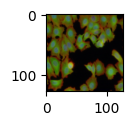

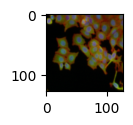

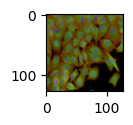

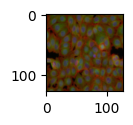

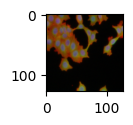

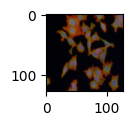

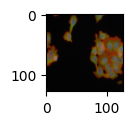

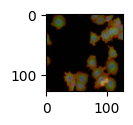

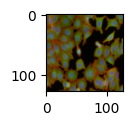

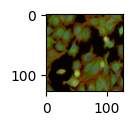

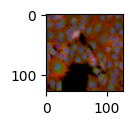

In [11]:
plot_n_images(controls_cytoch, 10, (1,1))

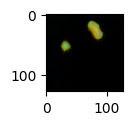

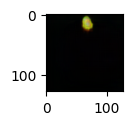

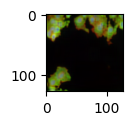

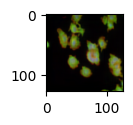

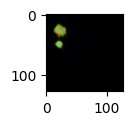

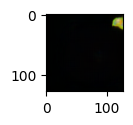

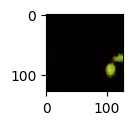

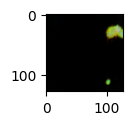

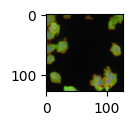

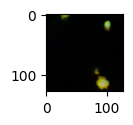

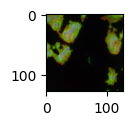

In [12]:
plot_n_images(transformed_cytoch, 10, (1,1))

Nocodazole

In [13]:
controls_noc, transformed_noc = transform_by_id(solver, dataloader, 100, "nocodazole", args)

100%|██████████| 217/217 [00:23<00:00,  9.08it/s]


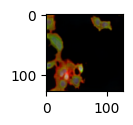

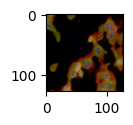

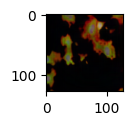

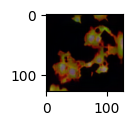

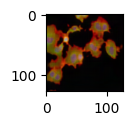

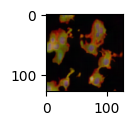

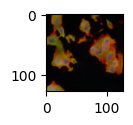

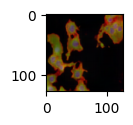

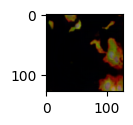

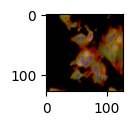

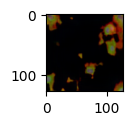

In [14]:
plot_n_images(transformed_noc, 10, (1,1))

simvastatin

In [15]:
controls_simv, transformed_simv = transform_by_id(solver, dataloader, 100, "simvastatin", args)

100%|██████████| 217/217 [00:23<00:00,  9.19it/s]


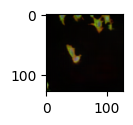

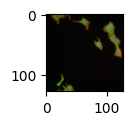

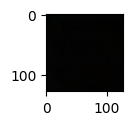

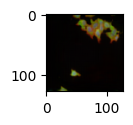

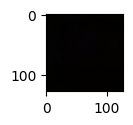

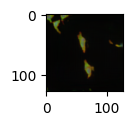

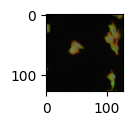

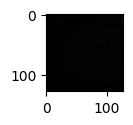

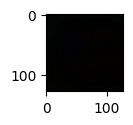

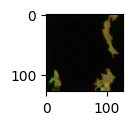

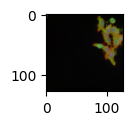

In [16]:
plot_n_images(transformed_simv, 10, (1,1))

mitomycin C

In [17]:
controls_mito, transformed_mito = transform_by_id(solver, dataloader, 100, "mitomycin C", args)

100%|██████████| 217/217 [00:23<00:00,  9.26it/s]


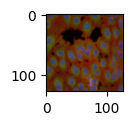

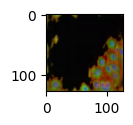

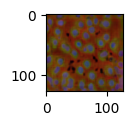

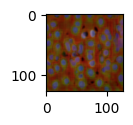

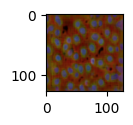

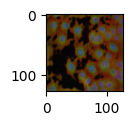

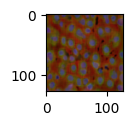

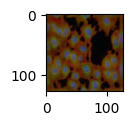

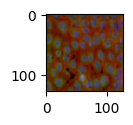

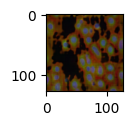

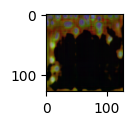

In [18]:
plot_n_images(transformed_mito, 10, (1,1))

In [19]:
controls_doce, transformed_doce = transform_by_id(solver, dataloader, 100, "docetaxel", args)

100%|██████████| 217/217 [00:23<00:00,  9.17it/s]


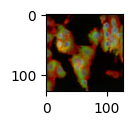

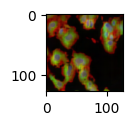

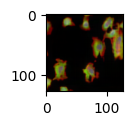

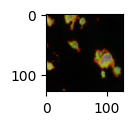

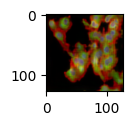

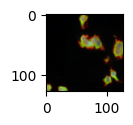

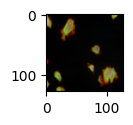

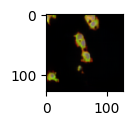

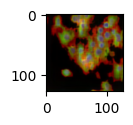

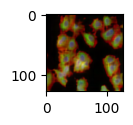

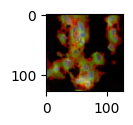

In [20]:
plot_n_images(transformed_doce, 10, (1,1))

In [21]:
controls_deme, transformed_deme = transform_by_id(solver, dataloader, 100, "demecolcine", args)

100%|██████████| 217/217 [00:22<00:00,  9.48it/s]


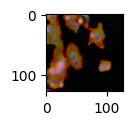

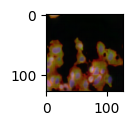

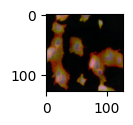

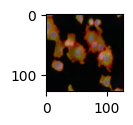

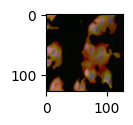

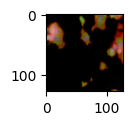

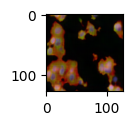

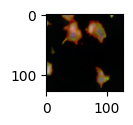

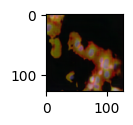

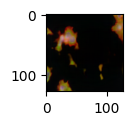

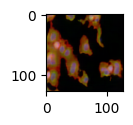

In [22]:
plot_n_images(transformed_deme, 10, (1,1))

In [23]:
controls_vincr, transformed_vincr = transform_by_id(solver, dataloader, 100, "vincristine", args)

100%|██████████| 217/217 [00:23<00:00,  9.21it/s]


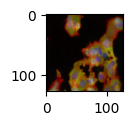

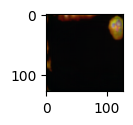

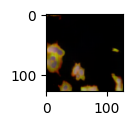

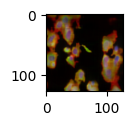

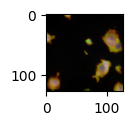

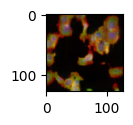

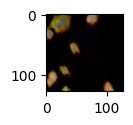

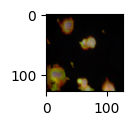

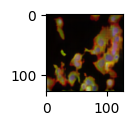

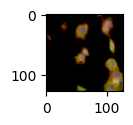

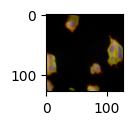

In [24]:
plot_n_images(transformed_vincr, 10, (1,1))

100%|██████████| 217/217 [00:23<00:00,  9.19it/s]


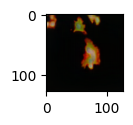

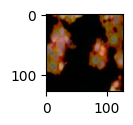

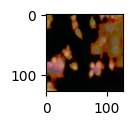

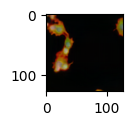

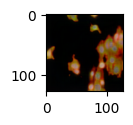

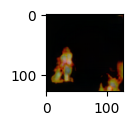

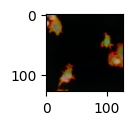

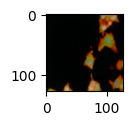

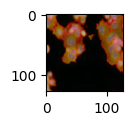

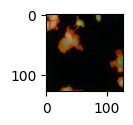

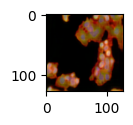

In [25]:
controls_AZ138, transformed_AZ138 = transform_by_id(solver, dataloader, 100, "AZ138", args)
plot_n_images(transformed_AZ138, 10, (1,1))

100%|██████████| 217/217 [00:23<00:00,  9.22it/s]


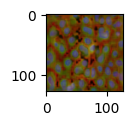

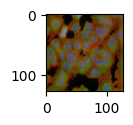

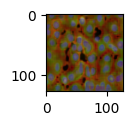

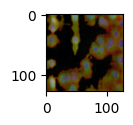

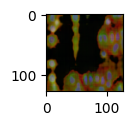

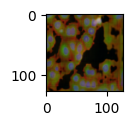

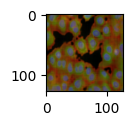

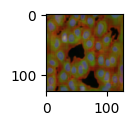

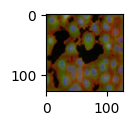

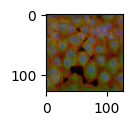

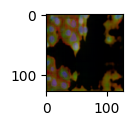

In [26]:
controls_AZ258, transformed_AZ258 = transform_by_id(solver, dataloader, 100, "AZ841", args)
plot_n_images(transformed_AZ258, 10, (1,1))

100%|██████████| 217/217 [00:19<00:00, 11.05it/s]


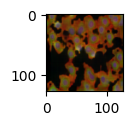

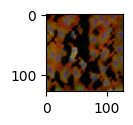

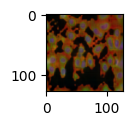

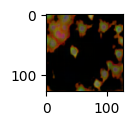

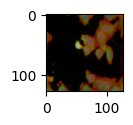

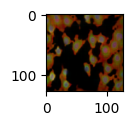

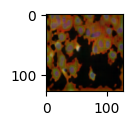

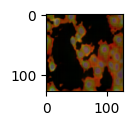

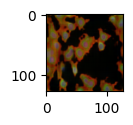

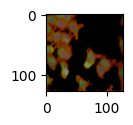

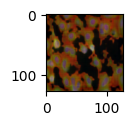

In [27]:
controls_metho, transformed_metho = transform_by_id(solver, dataloader, 100, "methotrexate", args)
plot_n_images(transformed_metho, 10, (1,1))

100%|██████████| 217/217 [00:12<00:00, 17.48it/s]


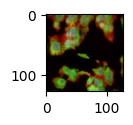

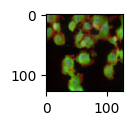

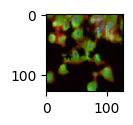

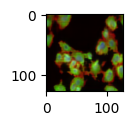

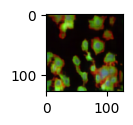

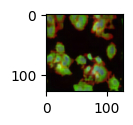

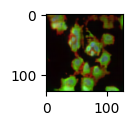

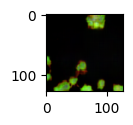

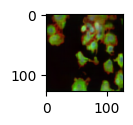

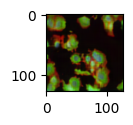

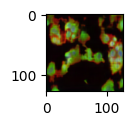

In [28]:
controls_epo, transformed_epo = transform_by_id(solver, dataloader, 100, "epothilone B", args)
plot_n_images(transformed_epo, 10, (1,1))

## Function to get real images of a drug 

In [29]:
taxol_images = get_real_cpd_images(dataloader, solver, "taxol")

100%|██████████| 217/217 [00:06<00:00, 32.68it/s]


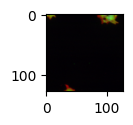

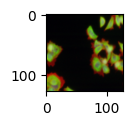

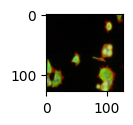

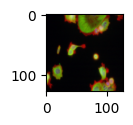

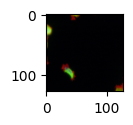

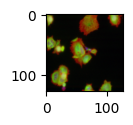

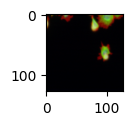

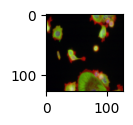

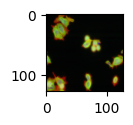

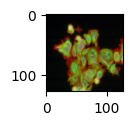

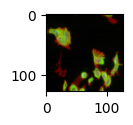

In [30]:
plot_n_images(taxol_images, 10, (1,1))

# Now get features for generated and real images 

In [31]:
from cellpose import models, utils
from skimage.feature import graycomatrix, graycoprops

from skimage.measure import regionprops, regionprops_table

CHANNELS = {0: "actin", 
            1: "tubulin", 
            2: "nucleus"}

def compute_texture_features(image):
    """
    Compute texture features using GLCM (Gray-Level Co-occurrence Matrix).

    Parameters:
    - image: grayscale image.

    Returns:
    - texture_features: dictionary containing texture features.
    """
    # Compute GLCM
    image_uint = (image*255.).astype(np.uint8)
    # Compute texture properties from GLCM
    texture_props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    texture_features = {}
    for ch in range(3):
        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        glcm = graycomatrix(image_uint[:, :, ch], distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
        

        for prop in texture_props:
            texture_features[prop+"_"+CHANNELS[ch]] = graycoprops(glcm, prop).ravel()[0]

    return texture_features

def cellpose_segmentation(images):
    """
    Perform Cellpose segmentation on a batch of images and measure all available region properties.

    Parameters:
    - images: numpy array of shape (N, H, W) containing N images.

    Returns:
    - region_props: a table of region properties for each segmented region.
    """
    # Define Cellpose model for 2D images
    model = models.Cellpose(gpu=True, model_type='cyto')  # gpu=True if you have GPU support

    region_props_res = {}
    texture_features_res = {}

    # Process each image in the batch
    for i in tqdm(range(len(images))):
        image = images[i]
        # Segment the cells
        masks, flows, styles, diams = model.eval(image, diameter=None, channels=[2, 3])

        # Get region properties
        props = regionprops_table(masks.astype(int), image, properties=('area', 'area_bbox', 'area_convex', 'area_filled',
                                                                'axis_major_length', 'axis_minor_length', 'bbox', 
                                                                'eccentricity', 'equivalent_diameter',
                                                                'euler_number', 'extent', 'feret_diameter_max', 
                                                                'intensity_max', 'intensity_mean', 'intensity_min', 'label', 'moments',
                                                                'moments_central', 'moments_hu', 'moments_normalized', 'moments_weighted',
                                                                'moments_weighted_central', 'moments_weighted_hu', 'moments_weighted_normalized',
                                                                 'perimeter', 'perimeter_crofton', 'solidity'))

        # Compute texture features
        texture_features = compute_texture_features(image)

        for key in props:
            if key in ['area', 'area', 'area_bbox', 'area_convex', 'area_filled', 'perimeter']:
                props_mean = np.sum(props[key])
            else:
                props_mean = np.mean(props[key])
            if key not in region_props_res:
                region_props_res[key] = np.array([props_mean])
            else:
                region_props_res[key] = np.concatenate([region_props_res[key], np.array([props_mean])])

        for key in texture_features:
            if key not in texture_features_res:
                texture_features_res[key] = np.array([texture_features[key]])
            else:
                texture_features_res[key] = np.concatenate([texture_features_res[key], np.array([texture_features[key]])])

        if "number_objs" not in region_props_res:
            region_props_res["number_objs"] = [np.max(masks)]
        else: 
            region_props_res["number_objs"].append(np.max(masks))
    return region_props_res, texture_features_res

def plot_boxplot(data, title='Boxplot', x="drug", y="values", hue="type", size=(3, 5), plot_path=None):
    """
    Plot a nice boxplot using seaborn with vertically oriented x-axis labels.

    Parameters:
        data (list or array-like): The data to be plotted.
        title (str): Title of the plot.
        x (str): Label for the x-axis.
        y (str): Label for the y-axis.
        hue (str): Grouping variable that will produce elements with different colors.
        size (tuple): Size of the plot.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=size)
    ax = sns.boxplot(data=data, x=x, y=y, hue=hue, palette="colorblind")
    
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Rotate x-axis labels vertically
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    if plot_path != None:
        plt.savefig(plot_path,
           dpi=300, bbox_inches='tight', format='svg')
    plt.show()

In [32]:
region_props_res, texture_features_res = cellpose_segmentation(taxol_images)

100%|██████████| 132/132 [01:15<00:00,  1.75it/s]


In [33]:
region_props_res_df = pd.DataFrame(region_props_res)

In [34]:
texture_features_res_df = pd.DataFrame(texture_features_res)

In [35]:
for c in region_props_res_df.columns:
    print(c)

area
area_bbox
area_convex
area_filled
axis_major_length
axis_minor_length
bbox-0
bbox-1
bbox-2
bbox-3
eccentricity
equivalent_diameter
euler_number
extent
feret_diameter_max
intensity_max-0
intensity_max-1
intensity_max-2
intensity_mean-0
intensity_mean-1
intensity_mean-2
intensity_min-0
intensity_min-1
intensity_min-2
label
moments-0-0
moments-0-1
moments-0-2
moments-0-3
moments-1-0
moments-1-1
moments-1-2
moments-1-3
moments-2-0
moments-2-1
moments-2-2
moments-2-3
moments-3-0
moments-3-1
moments-3-2
moments-3-3
moments_central-0-0
moments_central-0-1
moments_central-0-2
moments_central-0-3
moments_central-1-0
moments_central-1-1
moments_central-1-2
moments_central-1-3
moments_central-2-0
moments_central-2-1
moments_central-2-2
moments_central-2-3
moments_central-3-0
moments_central-3-1
moments_central-3-2
moments_central-3-3
moments_hu-0
moments_hu-1
moments_hu-2
moments_hu-3
moments_hu-4
moments_hu-5
moments_hu-6
moments_normalized-0-0
moments_normalized-0-1
moments_normalized-0-2


## Make feature barplot for drugs

In [36]:
true_drugs = {}
true_controls = {}
transformed_controls = {}
list_of_drugs = ['AZ138','AZ258','colchicine', 'cytochalasin B', 'demecolcine', 'epothilone B', 'simvastatin', 'taxol', 'vincristine']
# list_of_drugs = ['AZ138']

for drug in list_of_drugs:
    print(f"Collect {drug}")
    true_control, transformed_control = transform_by_id(solver, dataloader, 1, drug, args)
    true_drug = get_real_cpd_images(dataloader, solver, drug)

    true_drugs[drug] = true_drug
    true_controls[drug] = true_control
    transformed_controls[drug] = transformed_control 

Collect AZ138


100%|██████████| 217/217 [00:06<00:00, 32.77it/s]


Collect AZ258


100%|██████████| 217/217 [00:06<00:00, 34.43it/s]


Collect colchicine


100%|██████████| 217/217 [00:04<00:00, 45.35it/s]


Collect cytochalasin B


100%|██████████| 217/217 [00:05<00:00, 40.04it/s]


Collect demecolcine


100%|██████████| 217/217 [00:06<00:00, 34.76it/s]


Collect epothilone B


100%|██████████| 217/217 [00:05<00:00, 37.75it/s]


Collect simvastatin


100%|██████████| 217/217 [00:06<00:00, 34.95it/s]


Collect taxol


100%|██████████| 217/217 [00:06<00:00, 36.06it/s]


Collect vincristine


100%|██████████| 217/217 [00:06<00:00, 31.79it/s]


In [37]:
def extract_real_generated_features(true_drugs, true_controls, transformed_controls):
    # Create tge data 
    true_drugs_features = {}
    true_controls_features = {}
    transformed_controls_features = {}
    
    for drug in true_drugs: 
        # Draw features 
        true_drug_fea = cellpose_segmentation(true_drugs[drug][:100])
        true_control_fea = cellpose_segmentation(true_controls[drug][:100])
        transformed_control_fea = cellpose_segmentation(transformed_controls[drug][:100])
        
        true_drugs_features[drug] = true_drug_fea
        true_controls_features[drug] = true_control_fea
        transformed_controls_features[drug] = transformed_control_fea

    return true_drugs_features, true_controls_features, transformed_controls_features

In [38]:
true_drugs_features, true_controls_features, transformed_controls_features = extract_real_generated_features(true_drugs, true_controls, transformed_controls)

 82%|████████▏ | 82/100 [00:45<00:09,  1.80it/s]/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/skimage/measure/_regionprops.py:649: RuntimeWarning: invalid value encountered in divide
  tuple(M[_get_element(axis)] / M0 for axis in range(self._ndim)))
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/skimage/measure/_moments.py:326: RuntimeWarning: invalid value encountered in scalar divide
  nu[powers] = (mu[powers] / scale ** sum(powers)) / (mu0 ** (sum(powers) / nu.ndim + 1))
100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


In [45]:
def plot_feature(true_drugs_features, 
                 true_controls_features, 
                 transformed_controls_features, 
                 feature_to_plot):
    # Dictionary of values to plot
    to_plot = {'values': [], 'drug': [], 'type': []}
    
    for drug in true_drugs_features:
        true_drug_fea = list(true_drugs_features[drug][0][feature_to_plot])
        true_controls_fea = list(true_controls_features[drug][0][feature_to_plot])
        transformed_controls_fea = list(transformed_controls_features[drug][0][feature_to_plot])

        to_plot['values'] = to_plot['values'] +  true_controls_fea + transformed_controls_fea + true_drug_fea
        to_plot['drug'] += [drug[0].capitalize()+drug[1:] for _ in range(len(true_controls_fea)+len(transformed_controls_fea)+len(true_drug_fea))]
        to_plot['type'] = to_plot['type'] + ["controls"]*len(true_controls_fea) + ["IMPA"]*len(transformed_controls_fea) + ["drug"]*len(true_drug_fea)
    
    return to_plot

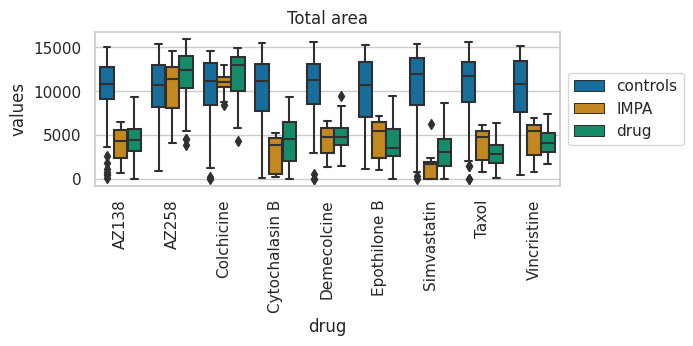

In [46]:
to_plot_area = plot_feature(true_drugs_features, 
                         true_controls_features, 
                         transformed_controls_features, 
                         "area")
to_plot_area_df = pd.DataFrame(to_plot_area)

plot_boxplot(to_plot_area_df, title='Total area', size=(6, 2), 
            plot_path="/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/total_area.svg")

In [50]:
to_plot_area_df.to_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/source_data/figure_2b_total_area.csv")

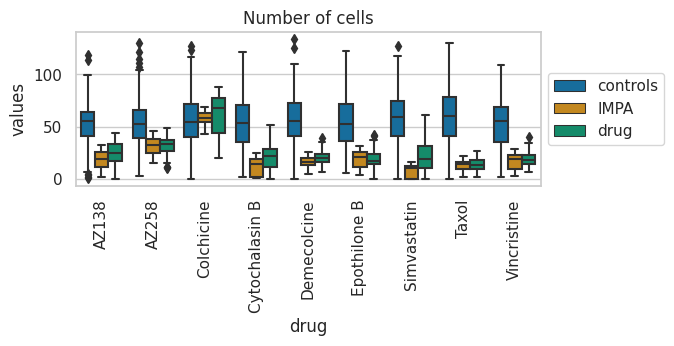

In [52]:
to_plot_n_objs = plot_feature(true_drugs_features, 
                         true_controls_features, 
                         transformed_controls_features, 
                         "number_objs")
to_plot_n_objs_df = pd.DataFrame(to_plot_n_objs)

plot_boxplot(to_plot_n_objs_df, title='Number of cells', size=(6, 2),
            plot_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/numer_of_cells.svg")

In [53]:
to_plot_area_df.to_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/source_data/figure_2b_number_objs.csv")